In [1]:
import torch
import numpy             as np
import matplotlib.pyplot as plt
import math

from sympy                    import *
from sympy                    import symbols, diff, simplify, exp, tanh, lambdify
from torch.optim              import Adam, LBFGS
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm                     import tqdm

init_printing()

***

# 1. Calculate expansion equation

In [2]:
# Run the file with all help functions

%run AppHor_conformal.ipynb

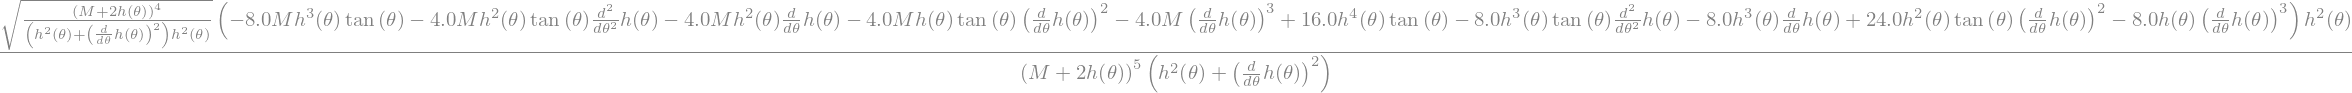

In [3]:
'''
Large function which calculates the expansion equation from alpha, beta, psi4, coordinates and h
'''



def final(alpha, beta, psi4, coords, h):
    '''
    param alpha: lapse function      --> function of (r, theta, phi)
    param beta: shift vector         --> 3-vector function of (r, theta, phi)
    param psi4: conformal factor     --> function of (r, theta, phi)
    param coords: coordinate system  --> list of coordinates
    param h: horizon function        --> scalar function dependent on theta, phi

    return: symbolic sympy expression of the expansion equation
    '''

    
    s_inv_norm = s_norm(h, s, psi4, coords, eta_inv)                    # inverse s-vector (normalized)
    
    christoffel = christoffel_symbols(psi4, eta, eta_inv, coords)       # Christoffel symbols of gamma 3-metric
    
    n_up = norm_up(alpha, beta, coords)                                 # normal vector to hypersurface (index up)
    
    n_down = norm_down(alpha, beta, psi4, eta, coords)                  # normal vector to hypersurface (index down)
    
    cur = extrinsic_curvature(n_up, n_down, christoffel, coords)        # extrinsic curvature (K_ij)
    
    exp = expansion(christoffel, s_inv_norm, cur, coords)               # expansion equation

    exp = exp.subs(r, h)                                                # replace all r by horizon function h

    
    return exp



exp_eq = sp.simplify(tan(theta)*final(alpha, beta, psi4, coords, h))
#exp_eq = sp.simplify(final(alpha, beta, psi4, coords, h))
display(sp.simplify(exp_eq))

In [4]:
# Define h as the spectral decomposition (this case: sin)
def spectral(w, N):
    h = w[0] + sum(w[2*i-1] * sin(i*theta) + w[2*i] * cos(i*theta) for i in range(1, N+1))
    return h


# Evaluate derivatives of h
def repl_der(expr, sub):
    for i in range(3):
        expr = expr.subs(sp.diff(h, theta, 2-i), sp.diff(sub, theta, 2-i))
    return expr

from sympy.printing.lambdarepr import lambdarepr

N = 2
w = sp.symbols(f'w0:{2*N+1}')

test = spectral(w, N)
expr_th = lambdarepr(repl_der(exp_eq, test))
print(expr_th)

sqrt((M + 2*w0 + 2*w1*math.sin(theta) + 2*w2*math.cos(theta) + 2*w3*math.sin(2*theta) + 2*w4*math.cos(2*theta))**4/(((w1*math.cos(theta) - w2*math.sin(theta) + 2*w3*math.cos(2*theta) - 2*w4*math.sin(2*theta))**2 + (w0 + w1*math.sin(theta) + w2*math.cos(theta) + w3*math.sin(2*theta) + w4*math.cos(2*theta))**2)*(w0 + w1*math.sin(theta) + w2*math.cos(theta) + w3*math.sin(2*theta) + w4*math.cos(2*theta))**2))*(w0 + w1*math.sin(theta) + w2*math.cos(theta) + w3*math.sin(2*theta) + w4*math.cos(2*theta))**2*(4.0*M*(w1*math.sin(theta) + w2*math.cos(theta) + 4*w3*math.sin(2*theta) + 4*w4*math.cos(2*theta))*(w0 + w1*math.sin(theta) + w2*math.cos(theta) + w3*math.sin(2*theta) + w4*math.cos(2*theta))**2*math.tan(theta) - 4.0*M*(w1*math.cos(theta) - w2*math.sin(theta) + 2*w3*math.cos(2*theta) - 2*w4*math.sin(2*theta))**3 - 4.0*M*(w1*math.cos(theta) - w2*math.sin(theta) + 2*w3*math.cos(2*theta) - 2*w4*math.sin(2*theta))**2*(w0 + w1*math.sin(theta) + w2*math.cos(theta) + w3*math.sin(2*theta) + w4*math

***

# 4. PyTorch solver (theta case)

In [5]:
# Replace variables in string into torch format
dic_theta = {"math.":"torch.", "sqrt":"torch.sqrt", "M":"2"}
for i in range(2*N+1):
    dic_theta[f'w{2*N-i}'] = f'w[{2*N-i}]'

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr_th = replace_all(expr_th, dic_theta)
print(expr_th)

torch.sqrt((2 + 2*w[0] + 2*w[1]*torch.sin(theta) + 2*w[2]*torch.cos(theta) + 2*w[3]*torch.sin(2*theta) + 2*w[4]*torch.cos(2*theta))**4/(((w[1]*torch.cos(theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta))**2 + (w[0] + w[1]*torch.sin(theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta))**2)*(w[0] + w[1]*torch.sin(theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta))**2))*(w[0] + w[1]*torch.sin(theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta))**2*(4.0*2*(w[1]*torch.sin(theta) + w[2]*torch.cos(theta) + 4*w[3]*torch.sin(2*theta) + 4*w[4]*torch.cos(2*theta))*(w[0] + w[1]*torch.sin(theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta))**2*torch.tan(theta) - 4.0*2*(w[1]*torch.cos(theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta))**3 - 4.0*2*(w[1]*torch.cos(theta) - w[2]*torch.sin(theta) + 2*w[3]*torc

In [6]:
N_th = 50
theta = torch.linspace(0, torch.pi, N_th, dtype=torch.float64)

w = torch.ones(2*N+1, dtype=torch.float64, requires_grad=True)
w.data = 0.1*w.data
w.data[0] = 10*w.data[0]

In [9]:
def w_loss(w, expr):
       
    # Define residual of the equation by evaluating the string expression above
    residual = eval(expr)
    #residual = (((w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))**2 + (w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**2)*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**2)*(4.0*2*(w[1]*torch.sin(theta) + 25*w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + 4*w[3]*torch.sin(2*theta) + 4*w[4]*torch.cos(2*theta) + 9*w[5]*torch.sin(3*theta) + 9*w[6]*torch.cos(3*theta) + 16*w[7]*torch.sin(4*theta) + 16*w[8]*torch.cos(4*theta) + 25*w[9]*torch.sin(5*theta))*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**2*torch.tan(theta) - 4.0*2*(w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))**3 - 4.0*2*(w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))**2*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))*torch.tan(theta) - 4.0*2*(w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**2 - 8.0*2*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**3*torch.tan(theta) + 8.0*(w[1]*torch.sin(theta) + 25*w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + 4*w[3]*torch.sin(2*theta) + 4*w[4]*torch.cos(2*theta) + 9*w[5]*torch.sin(3*theta) + 9*w[6]*torch.cos(3*theta) + 16*w[7]*torch.sin(4*theta) + 16*w[8]*torch.cos(4*theta) + 25*w[9]*torch.sin(5*theta))*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**3*torch.tan(theta) - 8.0*(w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))**3*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta)) + 24.0*(w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))**2*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**2*torch.tan(theta) - 8.0*(w[1]*torch.cos(theta) - 5*w[10]*torch.sin(5*theta) - w[2]*torch.sin(theta) + 2*w[3]*torch.cos(2*theta) - 2*w[4]*torch.sin(2*theta) + 3*w[5]*torch.cos(3*theta) - 3*w[6]*torch.sin(3*theta) + 4*w[7]*torch.cos(4*theta) - 4*w[8]*torch.sin(4*theta) + 5*w[9]*torch.cos(5*theta))*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**3 + 16.0*(w[0] + w[1]*torch.sin(theta) + w[10]*torch.cos(5*theta) + w[2]*torch.cos(theta) + w[3]*torch.sin(2*theta) + w[4]*torch.cos(2*theta) + w[5]*torch.sin(3*theta) + w[6]*torch.cos(3*theta) + w[7]*torch.sin(4*theta) + w[8]*torch.cos(4*theta) + w[9]*torch.sin(5*theta))**4*torch.tan(theta))
    
    # Return the mean squared residual
    return torch.mean(residual**2)

In [10]:
def solve_for_w(w, expr, N_iter=200, lr=0.1):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([w], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.2, patience=500)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = w_loss(w, expr)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return w, losses

In [11]:
w, w_losses = solve_for_w(w, expr_th, N_iter=1000, lr=0.01)

100%|██████████| 1000/1000 [00:09<00:00, 100.23it/s]


In [12]:
print(w)

tensor([ 9.7285e-01,  2.6840e-02,  9.2259e-10, -2.6576e-10,  5.3406e-03],
       dtype=torch.float64, requires_grad=True)


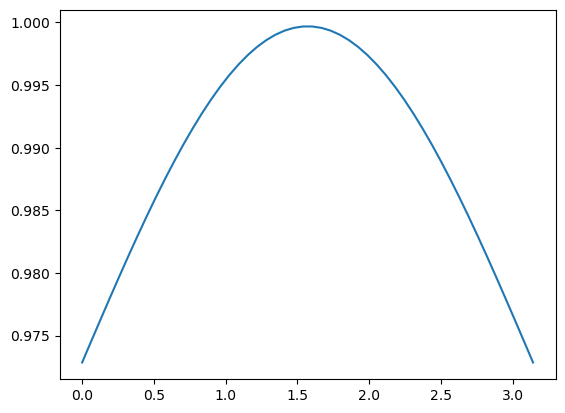

In [13]:
h_sol = w[0] * torch.ones(N_th)
for i in range(1, N):
    h_sol += w[i] * torch.sin(i*theta)

plt.plot(theta, h_sol.data)

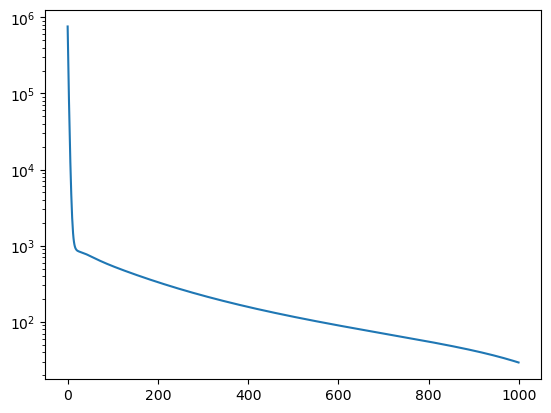

In [13]:
plt.plot(w_losses)
plt.yscale('log')

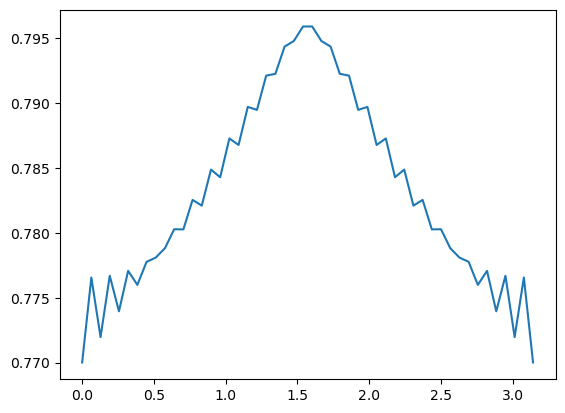

In [63]:
plt.plot(theta, h.data);

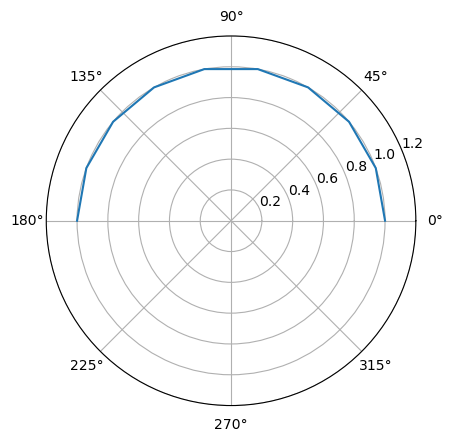

In [39]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
ax.plot(theta, h.data)
ax.set_rmax(1.2)
ax.grid(True)
plt.show()

<hr style="border:2px solid gray">

<hr style="border:2px solid gray">

<hr style="border:2px solid gray">

# Backup

In [ ]:
'''
Function which replaces theta derivatives with symbols and converts to a string



from sympy.printing.lambdarepr import lambdarepr


# Define functions and symbols (--> up to 5th order derivatives can be replaced)
x = Function('x')(theta)
y = Function('y')(theta)
z = Function('z')(theta)
u = Function('u')(theta)
v = Function('v')(theta)
H, X, Y, Z, U, V = symbols('H, X, Y, Z, U, V')
funcs_pre = [h, x, y, z, u, v]
syms_pre = [H, X, Y, Z, U, V]


# Replace each theta derivative with a unique symbol for string conversion
def subs_der(expr, nr_der):
    '''
    params expr: symbolic expression in which to replace derivatives
    params nr_der: highest order of desired derivative to be replaced

    return: string with r replaced by H and derivatives replaced by symbols X, Y, ...
    '''
    
    funcs = []
    syms = []
    for i in range(nr_der+1):
        funcs.append(funcs_pre[i])
        syms.append(syms_pre[i])
    n = len(funcs)
    expr = expr.subs(r, h)
    for i in range(n-1):
        expr = expr.subs(diff(funcs[i], theta), funcs[i+1])
    for i in range(n):
        expr = expr.subs(funcs[i], syms[i])
        
    return lambdarepr(expr)

symp_expr = subs_der(exp_eq, 2)
print(symp_expr)
'''

In [ ]:
'''
# Theta linspace
N_th = 3
theta = torch.linspace(0.001, torch.pi, N_th, dtype=torch.float64)
#a = torch.tensor([theta[0]])
#theta_new = torch.cat((theta, a))  # Add first element at the back of the tensor

# Initialize h-function
h = torch.ones(N_th, dtype=torch.float64, requires_grad=True)
h.data = 0.4*h.data
b = torch.tensor([h[0]])
h_new = torch.cat((h, b))  # Add first element at the back of the tensor

print(h)
'''

'''
d_th = torch.diff(theta)
mean_th = torch.mean(d_th)
print(mean_th)

d_h = torch.diff(h_new)


c = torch.tensor([d_th[0]])
d_th_new = torch.cat((d_th, c))
d = torch.tensor([d_h[0]])
d_h_new = torch.cat((d_h, d))

d2_th = torch.diff(d_th_new)
d2_h = torch.diff(d_h_new)

print(theta.shape, h.shape, d_th.shape, d_h.shape, d2_th.shape, d2_h.shape)
'''

'''
dic_solve = {"H":"h", "X":"(d_h/mean_th)", "Y":"(d2_h/mean_th)", "M":"1", "theta":"1"}
#dic_solve = {"H":"h", "X":"(d_h/d_th)", "Y":"0", "M":"1"}

def replace_solve(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(expr, dic_solve)
print(expr)
'''

In [ ]:
'''
Function which makes the string pytorch-compatible



#dic = {"math.sin(theta)":"1", "math.":"torch.", "sqrt":"torch.sqrt"}   # phi case (take sin(theta)=1)
dic = {"math.":"torch.", "sqrt":"torch.sqrt"}   # theta case

def replace_all(expr, dic):
    for i, j in dic.items():
        expr = expr.replace(i, j)
    return expr

expr = replace_all(symp_expr, dic)
#test_repl = replace_all(test, dic)

print(expr)
'''

***

# Old solver

In [9]:
Nr = 1
r = torch.ones(Nr, dtype=torch.float64, requires_grad=True)

def r_loss(r):
    # Define residual of the equation
    residual = 1/r**5 * ((r-1.5) * (1+2*r)**3)
    # Return the mean squared residual
    return torch.mean(residual**2)

In [10]:
def solve_for_r(r, N_iter=1000, lr=1.0e-3):
    # Define variable to store the loss history
    losses = np.empty(N_iter)
    # Define optimiser and scheduler
    optimiser = Adam([r], lr=lr)
    scheduler = ReduceLROnPlateau(optimiser, mode='min', factor=0.5, patience=200)
    # Iteratatively minimise loss
    for i in tqdm(range(N_iter)):
        # Compute the loss
        loss      = r_loss(r=r)
        losses[i] = loss.item()
        # Set gradients to zero
        optimiser.zero_grad()
        # Backpropagate gradients
        loss.backward()
        # Update parameters and scheduler
        optimiser.step()
        scheduler.step(loss)
    # Return result and loss history
    return r, losses

In [11]:
r, r_losses = solve_for_r(r=r, N_iter=10000, lr=1.0e-3)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:07<00:00, 1385.57it/s]


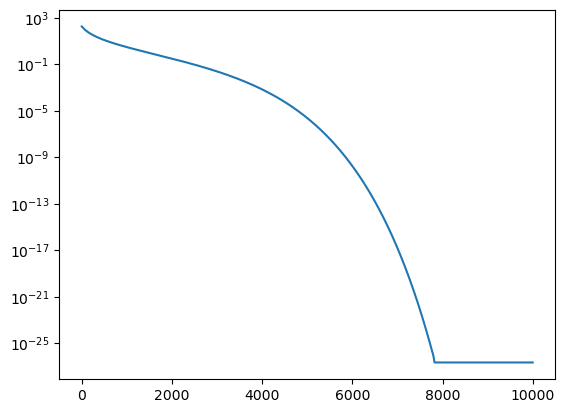

In [12]:
plt.plot(r_losses)
plt.yscale('log')

In [14]:
print(r)

tensor([1.5000], dtype=torch.float64, requires_grad=True)
